In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
def plot_mnist(data, classes, incorrect=None):
    for i in range(10):
        idxs = (classes == i) #조건에 맞는 index만 True 나머지는 False로 리턴된다.
        # 클래스 i에 해당하는 10개의 데이터
        
        if incorrect is not None:
            idxs *= incorrect
        
        images = data[idxs][0:10] #True조건을 만족하는 index로 data를 뽑고 그 중 10개를 뽑는다.
            
        for j in range(5):   
            plt.subplot(5, 10, i + j*10 + 1) # 행, 열, plot번호
            plt.imshow(images[j].reshape(28, 28), cmap='gray')
            # 클래스당 타이틀 표시
            if j == 0:
                plt.title(i)
            plt.axis('off')
    plt.show()

In [3]:
train_data = pd.read_csv("./mnist-in-csv/mnist_train.csv")
train_input = train_data.iloc[:,1:].values
train_input = np.reshape(train_input, [-1,28,28,1])

In [4]:
train_input.shape

(60000, 28, 28, 1)

In [5]:
train_label = train_data['label']
train_target = pd.get_dummies(train_label).values

In [6]:
test_data = pd.read_csv("./mnist-in-csv/mnist_test.csv")
test_input = test_data.iloc[:,1:].values
test_input = np.reshape(test_input, [-1,28,28,1])
test_label = test_data['label']
test_target = pd.get_dummies(test_label).values

In [7]:
np.shape(train_input)

(60000, 28, 28, 1)

In [8]:
with tf.name_scope('Input_Layer'):
    input_layer = tf.placeholder(tf.float32, [None, 28, 28, 1])

In [9]:
with tf.name_scope('Conv_Layer1'):
    conv1_kernel = tf.Variable(tf.random_uniform([5, 5, 1, 16], minval=-1, maxval=1),
                              dtype=tf.float32, name="Conv1_Kernel")
    conv1_bias = tf.Variable(tf.random_uniform([16], minval=-1, maxval=1),
                            dtype=tf.float32, name="Conv1_Bias")
    conv1_layer = tf.nn.conv2d(input_layer, conv1_kernel, 
                               strides=[1, 2, 2, 1], padding='SAME')
    conv1_layer = tf.nn.bias_add(conv1_layer, conv1_bias)
    conv1_relu = tf.nn.relu(conv1_layer)

In [10]:
conv1_relu.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(16)])

In [11]:
with tf.name_scope('Pooling_Layer1'):
    pool1_layer = tf.nn.max_pool(conv1_relu, 
                                 [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')

In [12]:
pool1_layer.shape

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(16)])

In [13]:
with tf.name_scope('Conv_Layer2'):
    conv2_kernel = tf.Variable(tf.random_uniform([3, 3, 16, 32], minval=-1, maxval=1),
                              dtype=tf.float32, name="Conv2_Kernel")
    conv2_bias = tf.Variable(tf.random_uniform([32], minval=-1, maxval=1),
                            dtype=tf.float32, name="Conv2_Bias")
    conv2_layer = tf.nn.conv2d(pool1_layer, conv2_kernel, 
                               strides=[1, 1, 1, 1], padding='SAME')
    conv2_layer = tf.nn.bias_add(conv2_layer, conv2_bias)
    conv2_relu = tf.nn.relu(conv2_layer)

In [14]:
conv2_relu.shape

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(32)])

In [15]:
with tf.name_scope('Pooling_Layer2'):
    pool2_layer = tf.nn.max_pool(conv2_relu, 
                                 [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')

In [16]:
pool2_layer.shape

TensorShape([Dimension(None), Dimension(3), Dimension(3), Dimension(32)])

In [17]:
with tf.name_scope('Hidden_Layer'):
    pool2_layer_flat = tf.reshape(pool2_layer, [-1, 3*3*32])
    hidden_weights = tf.Variable(tf.random_uniform([3*3*32, 100], minval=-1, maxval=1),
                                 dtype=tf.float32, name='Hidden_Weights')
    hidden_bias = tf.Variable(tf.random_uniform([100], minval=-1, maxval=1),
                             dtype=tf.float32, name='Hidden_Bias')
    hidden_layer = tf.nn.bias_add(tf.matmul(pool2_layer_flat, hidden_weights), hidden_bias)
    hidden_relu = tf.nn.relu(hidden_layer)

In [18]:
with tf.name_scope('Output_Layer'):
    output_weights = tf.Variable(tf.random_uniform([100, 10], minval=-1, maxval=1),
                                 dtype=tf.float32, name='Output_Weights')
    output_bias = tf.Variable(tf.random_uniform([10], minval=-1, maxval=1),
                             dtype=tf.float32, name='Output_Bias')
    output_layer = tf.nn.bias_add(tf.matmul(hidden_relu, output_weights), output_bias)

In [19]:
with tf.name_scope('Cost'):
    target = tf.placeholder(tf.float32, [None, 10])
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=target, 
                                                               logits=output_layer)
    cost = tf.reduce_mean(cross_entropy)

In [20]:
with tf.name_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005).minimize(cost)

In [21]:
with tf.name_scope('Metric'):
    accuracy = tf.metrics.accuracy(tf.argmax(target,1), tf.argmax(output_layer,1))

In [22]:
sess = tf.Session()
sess.run(tf.initializers.global_variables())

In [23]:
EPOCH = 10
BATCH = 10
BATCH_SIZE = 6000

In [24]:
for i in range(EPOCH):
    sess.run(tf.initializers.local_variables())

    for batch in range(BATCH):
        batch_input = train_input[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE]
        batch_target = train_target[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE]

        sess.run(optimizer, feed_dict={input_layer: batch_input,
                                       target: batch_target})

    train_cost, train_acc = sess.run([cost, accuracy], feed_dict={input_layer: train_input,
                                                                  target: train_target})
    print(i, train_cost, train_acc[1])

0 26711.69 0.21155
1 10635.226 0.39853334
2 5747.493 0.55946666
3 3874.2158 0.6523167
4 3060.224 0.70633334
5 2533.0674 0.74625
6 2186.5935 0.7735
7 1917.8004 0.7963
8 1706.1947 0.81413335
9 1537.4989 0.8294167


In [25]:
output_classes = sess.run(output_layer, feed_dict={input_layer: test_input})

In [26]:
output_label = np.argmax(output_classes, 1)

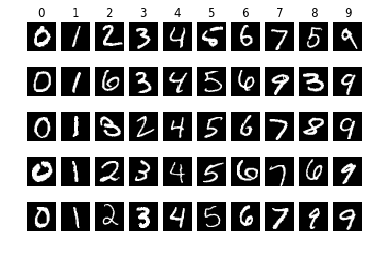

In [27]:
plot_mnist(test_input, output_label)